# Kaggle Competition¶

## House Prices: Advanced Regression Techniques

### Random Forest Regressor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
# First let's have a quick peek at the data description

data_description = open('data_description.txt', 'r')
print(data_description.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [4]:
print('The training set has {} rows and {} columns'.format(train_df.shape[0], train_df.shape[1]))
print('The test set has {} rows and {} columns'.format(test_df.shape[0], test_df.shape[1]))

The training set has 1460 rows and 81 columns
The test set has 1459 rows and 80 columns


In [5]:
# Numeric data

print(train_df.describe().transpose())

                count           mean           std      min        25%  \
Id             1460.0     730.500000    421.610009      1.0     365.75   
MSSubClass     1460.0      56.897260     42.300571     20.0      20.00   
LotFrontage    1201.0      70.049958     24.284752     21.0      59.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
OverallQual    1460.0       6.099315      1.382997      1.0       5.00   
OverallCond    1460.0       5.575342      1.112799      1.0       5.00   
YearBuilt      1460.0    1971.267808     30.202904   1872.0    1954.00   
YearRemodAdd   1460.0    1984.865753     20.645407   1950.0    1967.00   
MasVnrArea     1452.0     103.685262    181.066207      0.0       0.00   
BsmtFinSF1     1460.0     443.639726    456.098091      0.0       0.00   
BsmtFinSF2     1460.0      46.549315    161.319273      0.0       0.00   
BsmtUnfSF      1460.0     567.240411    441.866955      0.0     223.00   
TotalBsmtSF    1460.0    1057.429452  

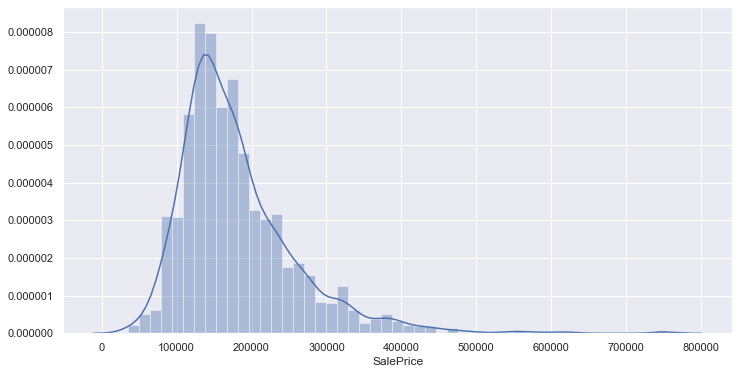

In [6]:
plt.figure(figsize=(12, 6))
sns.distplot(train_df['SalePrice'])

In [7]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [8]:
# Lets get rit of top and the borrom percentile to get rid of outliers

train_df = train_df[(train_df['SalePrice'] > train_df['SalePrice'].quantile(0.01))
                    & (train_df['SalePrice'] < train_df['SalePrice'].quantile(0.99))]

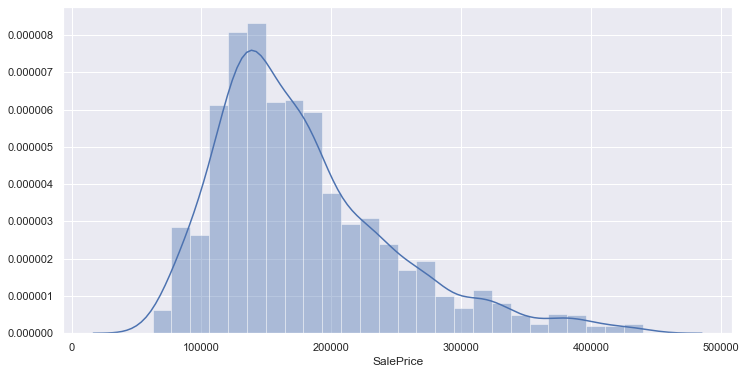

In [9]:
# Let's see if this looks any better

plt.figure(figsize=(12, 6))
sns.distplot(train_df['SalePrice'])

((array([-3.29931766, -3.04168924, -2.89839399, ...,  2.89839399,
          3.04168924,  3.29931766]),
  array([ 62383,  64500,  66500, ..., 437154, 438780, 440000], dtype=int64)),
 (66008.11098362254, 178410.36573426577, 0.9585500483950645))

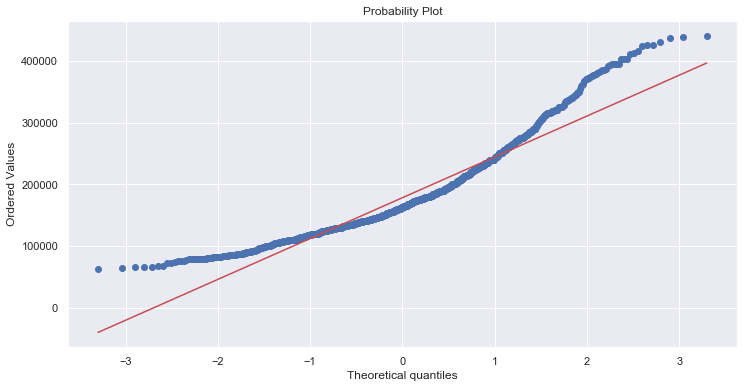

In [10]:
# how far are we from a perfect normal distribution?

plt.figure(figsize=(12, 6))
stats.probplot(train_df['SalePrice'], plot=plt)

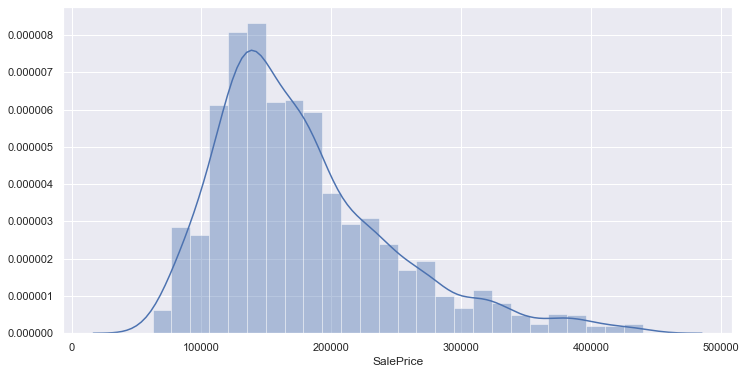

In [11]:
# Let's change the SalePrice column to log scale

train_df['LogSalePrice'] = np.log(train_df['SalePrice'])

plt.figure(figsize=(12, 6))
sns.distplot(train_df['SalePrice'])

((array([-3.29931766, -3.04168924, -2.89839399, ...,  2.89839399,
          3.04168924,  3.29931766]),
  array([11.04104808, 11.0744205 , 11.10495723, ..., 12.98804081,
         12.99175343, 12.99453001])),
 (0.3629093940919202, 12.02440334937545, 0.9969566704939036))

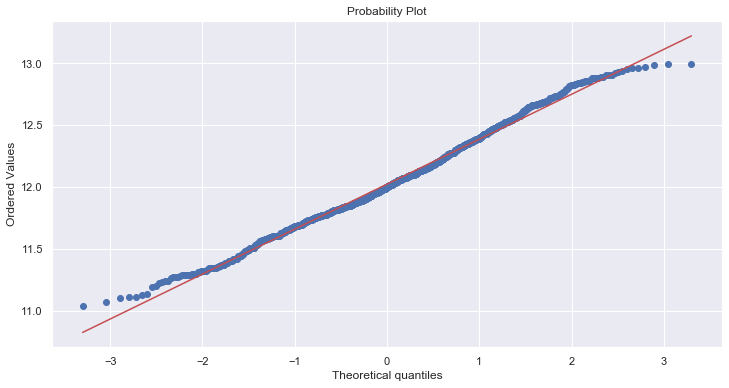

In [12]:
plt.figure(figsize=(12, 6))
stats.probplot(train_df['LogSalePrice'], plot=plt)

In [13]:
# Now that we have created LogSalePrice column, let's drop the SalePrice column

train_df.drop(columns='SalePrice', inplace=True)

In [14]:
# Exploring top correlations wih the LogSalePrice

correlations = train_df.corr()['LogSalePrice'].sort_values(ascending=False)
print(correlations)

LogSalePrice     1.000000
OverallQual      0.799220
GrLivArea        0.675425
GarageCars       0.661457
GarageArea       0.628710
YearBuilt        0.587757
TotalBsmtSF      0.585655
FullBath         0.578577
1stFlrSF         0.565820
YearRemodAdd     0.555966
GarageYrBlt      0.534618
TotRmsAbvGrd     0.493532
Fireplaces       0.475728
MasVnrArea       0.398468
LotFrontage      0.347679
BsmtFinSF1       0.339859
OpenPorchSF      0.336205
WoodDeckSF       0.322995
2ndFlrSF         0.296917
HalfBath         0.296520
LotArea          0.244990
BsmtFullBath     0.234310
BsmtUnfSF        0.220597
BedroomAbvGr     0.179928
ScreenPorch      0.098909
MoSold           0.061423
3SsnPorch        0.060871
PoolArea         0.040788
BsmtFinSF2      -0.002582
MiscVal         -0.007305
BsmtHalfBath    -0.018116
Id              -0.023094
YrSold          -0.028068
LowQualFinSF    -0.069045
OverallCond     -0.082600
MSSubClass      -0.088231
EnclosedPorch   -0.146783
KitchenAbvGr    -0.155561
Name: LogSal

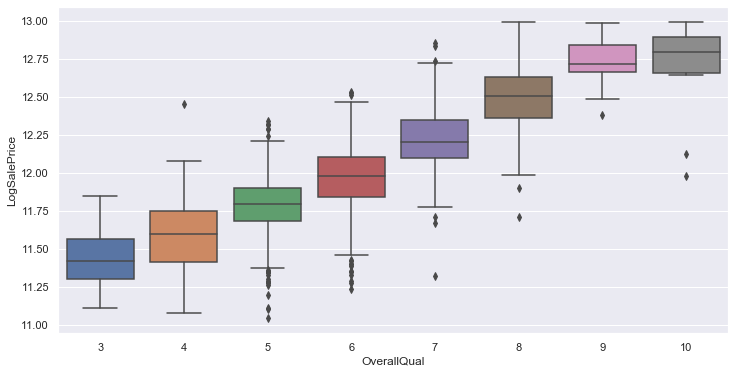

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='OverallQual', y='LogSalePrice', data=train_df)

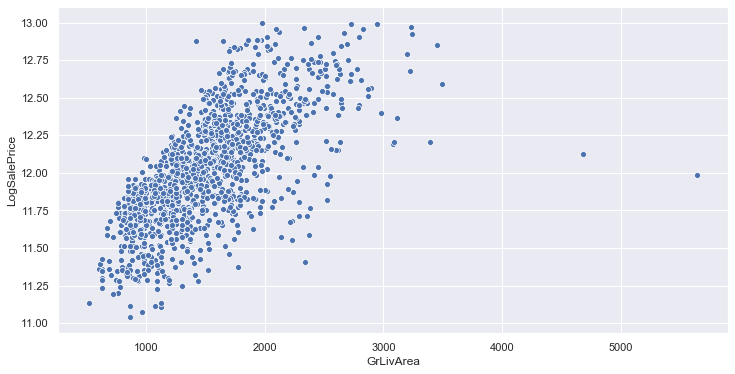

In [16]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='GrLivArea', y='LogSalePrice', data=train_df)

In [17]:
# Getting rid of the outliers, i.e. keeping only GrLivArea values smaller than than 4000

train_df = train_df[train_df['GrLivArea'] < 4000]

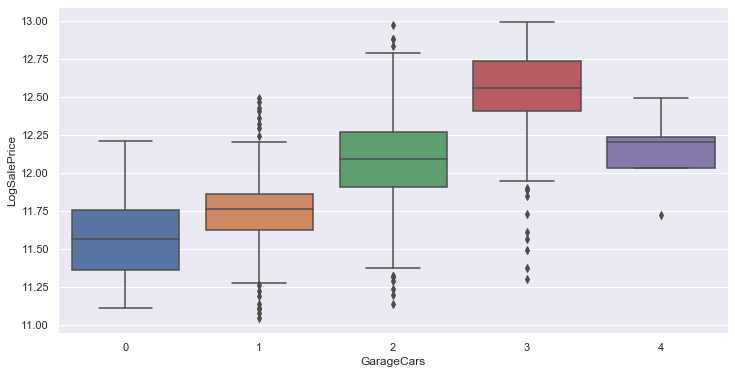

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='GarageCars', y='LogSalePrice', data=train_df)

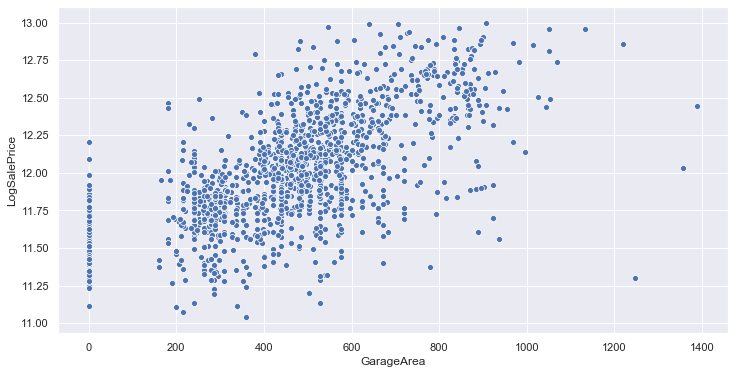

In [19]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='GarageArea', y='LogSalePrice', data=train_df)

In [20]:
# Let's drop GarageArea values greater than 1200

train_df = train_df[train_df['GarageArea'] < 1200]

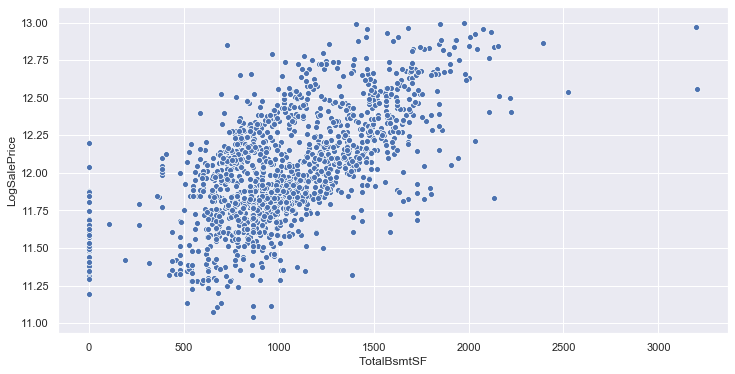

In [21]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='TotalBsmtSF', y='LogSalePrice', data=train_df)

In [22]:
# Get rid of extreme outliers, TotalBsmtSF > 3000

train_df = train_df[train_df['TotalBsmtSF'] < 3000]

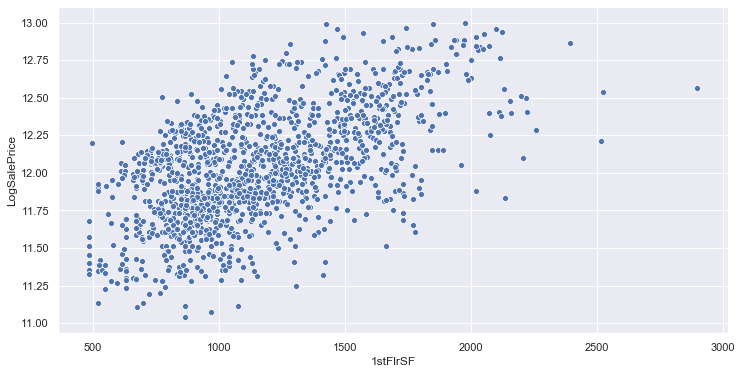

In [23]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='1stFlrSF', y='LogSalePrice', data=train_df)

In [24]:
# Here again we see some outliers, so lets get rid of 1stFlrSF greater than 2500

train_df = train_df[train_df['1stFlrSF'] < 2500]

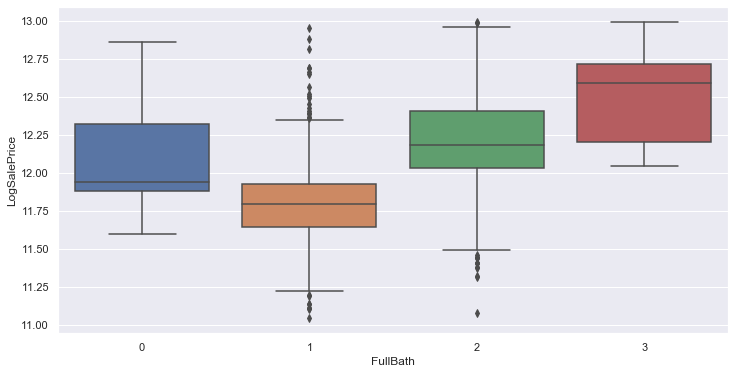

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='FullBath', y='LogSalePrice', data=train_df)

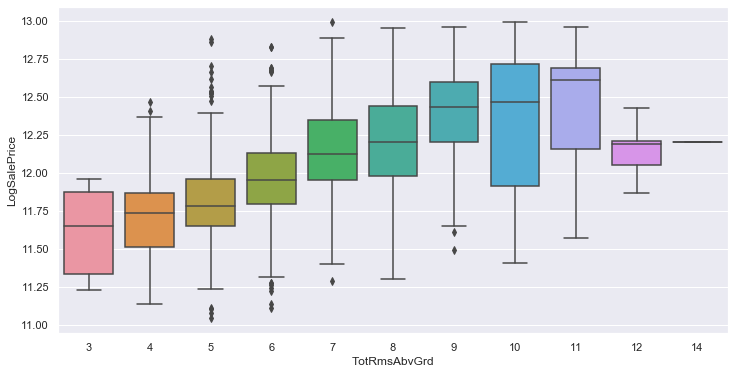

In [26]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='TotRmsAbvGrd', y='LogSalePrice', data=train_df)

In [27]:
train_df['TotRmsAbvGrd'].value_counts()

6     399
7     324
5     271
8     185
4      91
9      72
10     40
3      16
11     13
12      7
14      1
Name: TotRmsAbvGrd, dtype: int64

In [28]:
# Looking at the chart above it looks like we have outliers on both ends. 
# Lets keep only the houses from 3 to 12 TotRmsAbvGrd

train_df = train_df[(train_df['TotRmsAbvGrd'] > 2) & (train_df['TotRmsAbvGrd'] < 13)]

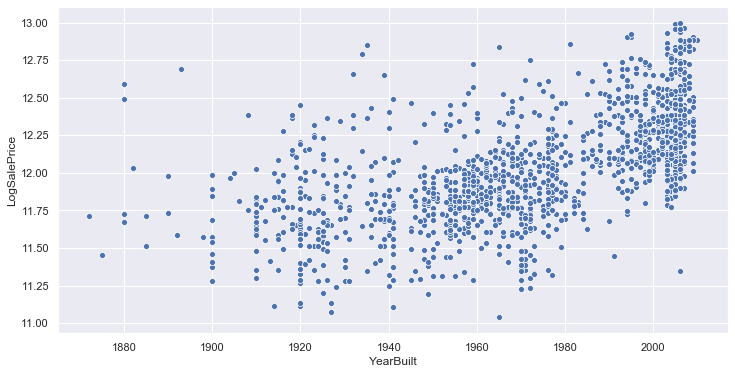

In [29]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='YearBuilt', y='LogSalePrice', data=train_df)

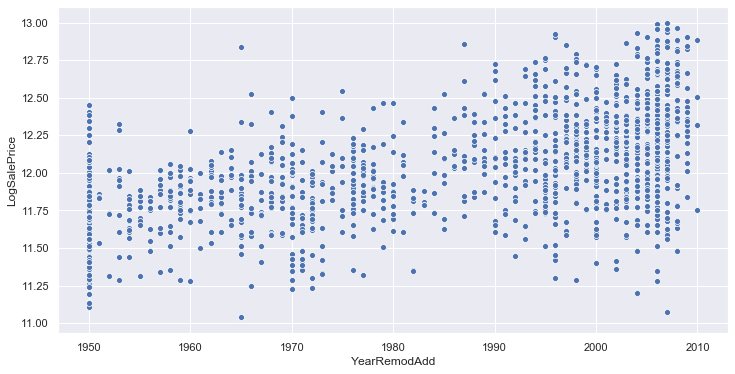

In [30]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='YearRemodAdd', y='LogSalePrice', data=train_df)

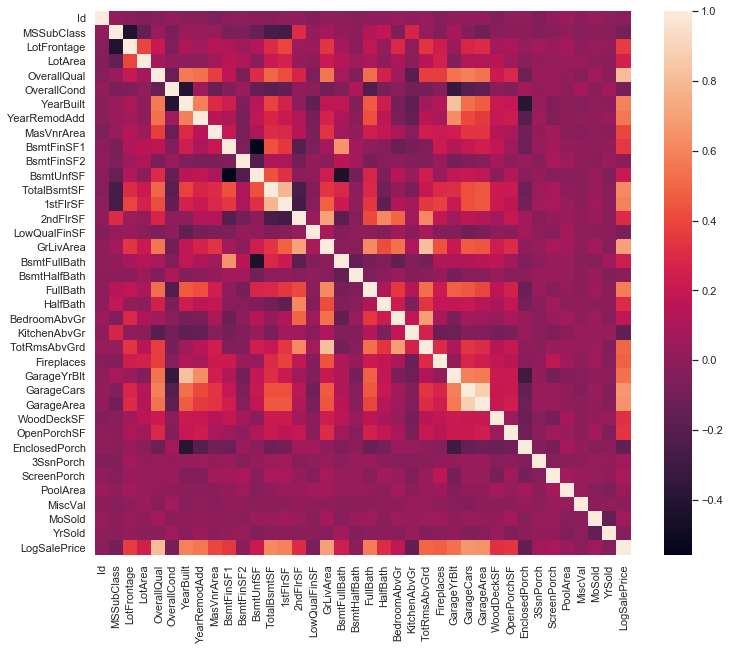

In [31]:
plt.figure(figsize=(12, 10))
sns.heatmap(train_df.corr())

In [32]:
combined_data = pd.concat((train_df, test_df), axis=0)

In [33]:
combined_data.isna().sum().sort_values(ascending=False).head(25)

PoolQC          2869
MiscFeature     2775
Alley           2683
Fence           2313
LogSalePrice    1459
FireplaceQu     1404
LotFrontage      480
GarageQual       149
GarageYrBlt      149
GarageFinish     149
GarageCond       149
GarageType       147
BsmtExposure      80
BsmtCond          80
BsmtQual          79
BsmtFinType1      77
BsmtFinType2      77
MasVnrType        22
MasVnrArea        21
MSZoning           4
Utilities          2
Functional         2
BsmtFullBath       2
BsmtHalfBath       2
GarageArea         1
dtype: int64

In [34]:
# Categorical columns with missing values, where the missing value should be 'NA'

cat_with_missing = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageQual', 
                    'GarageFinish',  'GarageCond', 'GarageType', 'GarageFinish', 'GarageCond', 
                    'GarageType', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType1', 
                    'BsmtFinType2', 'MasVnrType']

for each in cat_with_missing :
    combined_data[each] = combined_data[each].fillna('NA')

In [35]:
# Test

(combined_data['BsmtFinSF1'] + combined_data['BsmtFinSF2'] + combined_data['BsmtUnfSF']).sum() == combined_data['TotalBsmtSF'].sum()

True

In [36]:
# There is no point keeping 'TotalBsmtSF' since this feature simply sums the other features
# So, we drop it and full 0.0 in res of the numeric columns below

combined_data.drop(columns='TotalBsmtSF', inplace=True)

for each in ['BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'BsmtHalfBath', 'BsmtFullBath', 'MasVnrArea'] :
    combined_data[each] = combined_data[each].fillna(0.0)

In [37]:
# We fill the missing values with most common occurances

combined_data['MSZoning'] = combined_data['MSZoning'].fillna('RL')
combined_data['Utilities'] = combined_data['Utilities'].fillna('AllPub')
combined_data['Functional'] = combined_data['Functional'].fillna('Typ')
combined_data['Exterior1st'] = combined_data['Exterior1st'].fillna('VinylSd')
combined_data['Exterior2nd'] = combined_data['Exterior2nd'].fillna('VinylSd')
combined_data['Electrical'] = combined_data['Electrical'].fillna('SBrkr')
combined_data['GarageCars'] = combined_data['GarageCars'].fillna(2.0)
combined_data['SaleType'] = combined_data['SaleType'].fillna('WD')
combined_data['KitchenQual'] = combined_data['KitchenQual'].fillna('TA')

# The missing 'GarageArea' property actually has a garage with 2 cars, so we fill the missing value with mean
combined_data['GarageArea'] = combined_data['GarageArea'].fillna(combined_data['GarageArea'].mean())

In [38]:
# converting 'MSSubClass' to str type so the feature can be used as a categorical, rather than 
# a numerical continuous one

combined_data['MSSubClass'] = combined_data['MSSubClass'].astype('str')

In [39]:
combined_data['GarageYrBlt'] = combined_data['GarageYrBlt'].fillna(combined_data['YearBuilt'])

In [40]:
combined_data.drop(columns=['YearBuilt', 'Electrical', 'LotFrontage'], inplace=True)

In [41]:
grading_dict = {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, 'NA' : 0}

combined_data['ExterQual'] = combined_data['ExterQual'].map(grading_dict)
combined_data['ExterCond'] = combined_data['ExterCond'].map(grading_dict)
combined_data['BsmtQual'] = combined_data['BsmtQual'].map(grading_dict)
combined_data['BsmtCond'] = combined_data['BsmtCond'].map(grading_dict)
combined_data['BsmtExposure'] = combined_data['BsmtExposure'].map({'Gd' : 5, 'Av' : 4, 'Mn' : 3, 
                                                                   'No' : 1, 'NA' : 0})
combined_data['BsmtFinType1'] = combined_data['BsmtFinType1'].map({'GLQ' : 6, 'ALQ' : 5, 'BLQ' : 4, 
                                                                  'Rec' : 3, 'LwQ' : 2, 'Unf' : 1, 
                                                                  'NA' : 0})
combined_data['BsmtFinType2'] = combined_data['BsmtFinType2'].map({'GLQ' : 6, 'ALQ' : 5, 'BLQ' : 4, 
                                                                  'Rec' : 3, 'LwQ' : 2, 'Unf' : 1, 
                                                                  'NA' : 0})
combined_data['HeatingQC'] = combined_data['HeatingQC'].map(grading_dict)
combined_data['CentralAir'] = combined_data['CentralAir'].map({'Y' : 1, 'N' : 0})
combined_data['KitchenQual'] = combined_data['KitchenQual'].map(grading_dict)
combined_data['Functional'] = combined_data['Functional'].map({'Typ' : 7, 'Min2' : 6, 'Min1' : 5, 
                                                               'Mod' : 4, 'Maj1' : 3, 'Maj2' : 2, 
                                                               'Sev' : 1, 'Sal' : 0})

In [42]:
combined_data.isna().sum().sort_values(ascending=False).head()

LogSalePrice    1459
Foundation         0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
dtype: int64

In [43]:
combined_data.shape

(2877, 77)

In [44]:
combined_data = pd.get_dummies(combined_data, drop_first=True)
combined_data.shape

(2877, 234)

In [45]:
# Split the data back to orifinal training and testing sets

train = combined_data[combined_data['LogSalePrice'].notna()].drop(columns='Id')
test = combined_data[combined_data['LogSalePrice'].isna()]
test_id = test['Id']
test = test.drop(columns=['Id', 'LogSalePrice'])

In [46]:
X = train.drop(columns='LogSalePrice').values
y = train['LogSalePrice']

Here are the results from the previous two rounds of running Gridsearch

Test 1 {'bootstrap': False, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}

Test 2 {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 700}

Below is the final gridsearch to fine tune the parameters further

In [47]:
grid = {'bootstrap' : [False], 'max_depth' : [60], 
        'max_features' : ['sqrt'], 'min_samples_leaf' : [1], 
        'min_samples_split' : [3], 
        'n_estimators' : [300, 400, 500, 600]}

gridsearch = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, n_jobs=-1, verbose=3, cv=5)

gridsearch.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    6.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    7.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [48]:
gridsearch.best_params_

{'bootstrap': False,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 600}

In [49]:
rfr = RandomForestRegressor(**gridsearch.best_params_)

rfr.fit(X, y)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=60, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      n_estimators=600, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [50]:
rfr_preds = rfr.predict(test)
rfr_preds = pd.Series(np.exp(rfr_preds))

In [51]:
x = pd.concat([test_id, rfr_preds], axis=1, keys=['Id', 'SalePrice'])
x

,Id,SalePrice
0,1461,123012.982941
1,1462,150469.031646
2,1463,182091.863313
3,1464,187206.341520
4,1465,187746.543304
...,...,...
1454,2915,90115.291024
1455,2916,88899.316200
1456,2917,157126.476349
1457,2918,106155.827707
